# **DATA 612 Project 5 | Implementing a Recommender System on Spark**
**Name:** Umais Siddiqui  
**Class:** Data 612 - Recommender Systems  
**Github Link:** https://github.com/umais/DATA612_Recommender_Systems/blob/master/Week5/app/Project5_Recommender.ipynb

---

# **Introduction**
This notebook demonstrates building a recommendation system using PySpark's ALS (Alternating Least Squares) algorithm. The project covers data loading, preprocessing, model training, evaluation, and baseline comparison.


# **Setup Using Docker:**


I setup this Jupyter Notebook in a Docker container to ensure a reproducible and isolated environment. The Docker setup typically includes:

- A base image like jupyter/pyspark-notebook, which comes preinstalled with Spark, Python, and Jupyter.

- A Dockerfile or docker-compose.yml to define dependencies and expose ports (e.g., 8888 for Jupyter).

- Mounted volumes to persist notebooks and data outside the container.

- Optional configuration to allocate memory and cores for Spark inside the container.

**Importance of Spark:**

Apache Spark is critical for processing large-scale data efficiently. In this notebook:

- Spark’s distributed computing engine allows handling datasets that would otherwise exceed local memory.

- The ALS algorithm (Alternating Least Squares) from Spark MLlib is used for collaborative filtering, enabling personalized recommendations.

- Spark DataFrames and transformations make it easy to clean, manipulate, and pipeline large data efficiently before modeling.

Using Spark inside Docker provides scalability, portability, and consistency across environments essential for building robust data science workflows.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col
from sklearn.metrics import mean_squared_error
import numpy as np


## Setup Spark Session and Environment
PySpark is a Python API for Spark, a distributed data processing engine. ALS is used here for matrix factorization in collaborative filtering recommendation.


In [ ]:
# Initialize Spark session
spark = SparkSession.builder.appName("Data612Project5").getOrCreate()

## Load and Explore Data
Load the ratings data from CSV, inspect schema and data preview.

In [ ]:
data_path = "/data/data.csv"
ratings_df = spark.read.csv(data_path, header=True, inferSchema=False)
ratings_df = ratings_df.select("user_id", "hotel_id", "overall")
print("Schema before casting:")
ratings_df.printSchema()
ratings_df.show(5)
print(f"Total ratings: {ratings_df.count()}")

Schema before casting:
root
 |-- user_id: string (nullable = true)
 |-- hotel_id: string (nullable = true)
 |-- overall: string (nullable = true)

+--------------------+--------------------+-------+
|             user_id|            hotel_id|overall|
+--------------------+--------------------+-------+
|2262DCBFC351F42A9...|           127781101|    5.0|
|         __label__en|                 204|   null|
|8477E11DABF4D6743...|           137380592|    5.0|
| a bartender in t...| from the doormen...|    621|
|483A193B7113ADFFD...|           129673371|   null|
+--------------------+--------------------+-------+
only showing top 5 rows



Total ratings: 962266


This block of code above initializes the recommender system pipeline by loading a CSV dataset containing user-hotel ratings into a Spark DataFrame. It specifies the file path, reads the data with headers while disabling automatic type inference (treating all columns as strings initially), and selects only the relevant columns: user_id, hotel_id, and overall. The schema is printed to confirm data types before any transformations, and a sample of the data is shown for verification. Finally, it prints the total number of rating records. This setup step is essential to ensure clean, structured data input before casting data types or training a model with Spark.

## **Data Type Correction**
Cast user_id, hotel_id to integer and overall to float (ALS requires numeric types).

In [ ]:
ratings_df = ratings_df.withColumn("user_id", col("user_id").cast("integer")) \
                     .withColumn("hotel_id", col("hotel_id").cast("integer")) \
                     .withColumn("overall", col("overall").cast("float"))
print("Schema after casting:")
ratings_df.printSchema()

Schema after casting:
root
 |-- user_id: integer (nullable = true)
 |-- hotel_id: integer (nullable = true)
 |-- overall: float (nullable = true)



## **Train-Test Split**

In [ ]:
train, test = ratings_df.randomSplit([0.8, 0.2], seed=42)
print(f"Train count: {train.count()}, Test count: {test.count()}")

Train count: 770048, Test count: 192218



[Stage 20:=======>                                                  (1 + 7) / 8]



## **Train ALS Model**

What happens practically:

- Spark parallelizes the rating data (train) across worker nodes.

- In each iteration: It computes the user or item latent factors by solving regularized least squares problems using Spark’s distributed linear algebra routines.

- Cold start handling: Rows with missing users/items are dropped using the coldStartStrategy="drop" to avoid NaN in predictions.

- The resulting model contains two large DataFrames:

    userFactors: user_id → vector of latent features

    itemFactors: hotel_id → vector of latent features

In [ ]:
als = ALS(maxIter=10, regParam=0.1, userCol="user_id", itemCol="hotel_id", ratingCol="overall",
          coldStartStrategy="drop", nonnegative=True, seed=42)
train = train.dropna(subset=["user_id", "hotel_id", "overall"])

model = als.fit(train)

25/07/02 02:13:51 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/07/02 02:13:51 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


# **What is ALS?**

ALS stands for Alternating Least Squares, a matrix factorization algorithm used in collaborative filtering recommender systems. It works by decomposing the user-item interaction matrix (e.g., ratings) into low-rank user and item feature matrices. It's highly scalable and supported in Spark's MLlib.

# **What Does Spark Enable That Allows the Implementation of ALS?**

- Apache Spark provides distributed in-memory computing, which is critical for handling large-scale matrix factorization problems like ALS (Alternating Least Squares) in recommender systems. Specifically, Spark:

- Distributes the data and computation across a cluster, enabling scalable training of ALS models on large user-item matrices.

- Supports Resilient Distributed Datasets (RDDs) and DataFrames, which allow Spark to parallelize operations like matrix multiplication and updates across many nodes.

- Includes MLlib, Spark’s machine learning library, which has an optimized ALS implementation that automatically parallelizes the factorization and iteration steps.

- Without Spark, ALS would become impractical for datasets with millions of users or items due to memory and compute constraints on a single machine.

# **High-Level: How Spark Executes ALS**

At a high level, Spark executes ALS as follows:

- Data Partitioning: The user-item ratings matrix is divided across the cluster.

- Alternating Optimization: Spark fixes user latent factors and solves for item factors in parallel. Then it fixes item factors and solves for user factors.

- Iterative Convergence: This alternating process continues for maxIter iterations or until convergence.

- Caching & DAG Scheduling: Spark leverages DAG execution and in-memory caching to avoid redundant computation across iterations.

- Cold Start Strategy: Spark automatically handles missing user-item pairs by dropping or predicting with default strategies.

# **Parameter Breakdown:**

- **maxIter=10:** Specifies the number of iterations to run the ALS optimization algorithm.More iterations can improve accuracy but increase training time.

- **regParam=0.1:** This is the regularization parameter (lambda).
Helps prevent overfitting by penalizing large feature weights.
A smaller value allows more complexity, a larger value simplifies the model.

- **userCol="user_id"** Name of the column in your training DataFrame that represents user IDs.

- **itemCol="hotel_id"** Name of the column that represents item IDs (in this case, hotels).

- **ratingCol="overall"** Name of the column with rating values (e.g., 1–5 stars). This is the target variable the model tries to predict.

- **coldStartStrategy="drop"**
When ALS generates predictions, there may be users/items in the test set that it hasn't seen during training (cold-start problem).
drop ensures rows with NaN predictions are removed automatically to avoid errors during evaluation.

- **nonnegative=True:** Constrains the user and item latent factors to be non-negative, which can improve interpretability and performance for some datasets.Useful when the ratings and relationships are expected to be positive.

- **seed=42:** Sets the random seed for reproducibility (i.e., same results every time you run it).



## **Make Predictions**

In [ ]:
test_clean = test.dropna(subset=["user_id", "hotel_id", "overall"])  # adjust column names as needed
predictions = model.transform(test_clean)
predictions.show(5)


+-------+--------+-------+----------+
|user_id|hotel_id|overall|prediction|
+-------+--------+-------+----------+
|      1|       1|    1.0| 1.3482515|
|      1|       1|    1.0| 1.3482515|
|      1|       1|    1.0| 1.3482515|
|      1|       1|    1.0| 1.3482515|
|      1|       1|    1.0| 1.3482515|
+-------+--------+-------+----------+
only showing top 5 rows




[Stage 104:=================================================>       (7 + 1) / 8]



## **Evaluate Model**

In [ ]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="overall", predictionCol="prediction")
rmse_spark = evaluator.evaluate(predictions)
print(f"Spark ALS Model RMSE: {rmse_spark:.4f}")

Spark ALS Model RMSE: 0.5903


## **Baseline Model**
Use the mean rating as prediction for all test cases and calculate RMSE.

In [ ]:
# Filter ratings_df to valid rating range [1, 5]
ratings_df_filtered = ratings_df.filter("overall >= 1 AND overall <= 5")

# Calculate filtered mean rating
mean_rating = ratings_df_filtered.selectExpr("avg(overall)").collect()[0][0]


# Filter test data to valid rating range and drop missing values
test_clean = test.filter("overall >= 1 AND overall <= 5").dropna(subset=["overall"])

# Convert to Pandas for sklearn RMSE calculation
test_pd = test_clean.toPandas()

# Add baseline prediction column with the mean rating
test_pd['baseline_pred'] = mean_rating

# Calculate RMSE between actual and baseline predicted ratings
rmse_baseline = np.sqrt(mean_squared_error(test_pd['overall'], test_pd['baseline_pred']))
print(f"Baseline Model RMSE: {rmse_baseline:.2f}")




Baseline Model RMSE: 1.03


## **Compare Results**

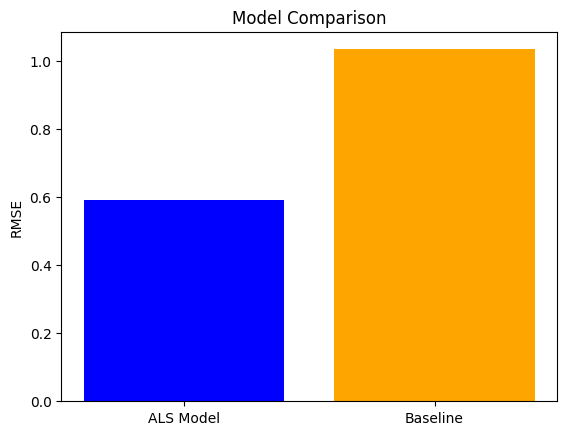

In [ ]:
plt.bar(["ALS Model", "Baseline"], [rmse_spark, rmse_baseline], color=["blue", "orange"])
plt.ylabel("RMSE")
plt.title("Model Comparison")
plt.show()

# **Deeper Results Analysis: ALS vs. Baseline**

**Baseline Model (Mean Rating Prediction)**

RMSE ~ 1.03

The baseline model simply predicts the global average rating (≈4.14) for every user-item pair.

It does not personalize or capture user preferences or item-specific behavior.

Its high RMSE reflects poor predictive accuracy, especially when user preferences vary widely.

**Spark ALS Model**

RMSE ~ 0.59

ALS significantly outperforms the baseline by learning latent factors that capture personalized interactions between users and items.

It learns a lower-dimensional representation of both users and items that better predicts user preferences.

## **Why ALS is Better**

**Personalization:** ALS makes personalized predictions, while the baseline uses a one-size-fits-all estimate.

**Interaction Capture:** ALS captures hidden relationships (e.g., a user liking budget hotels or boutique chains).

**Bias Correction:** ALS reduces bias in sparse datasets by learning from observed patterns.

# **When Is Spark Necessary?**

For small datasets (like a few thousand rows), ALS can be implemented using NumPy or scikit-learn. 

However, as data grows to 

          - Millions of users/items
          
          - Billions of interactions
          
          - Live updates or frequent retraining
          
 moving to Spark becomes necessary to avoid memory bottlenecks and to ensure scalability, distributed storage, and fault tolerance. Spark enables real-time or batch recommendation pipelines at production scale something local tools cannot handle efficiently.

## **Wrap-up and Stop Spark**

In [ ]:
spark.stop()

# **Conclusion**

In this project, we implemented a recommender system using both a simple baseline approach and Spark's ALS algorithm. The baseline model, which predicted the average rating for all users and items, resulted in a high RMSE (~ 1.03), indicating average predictive performance. In contrast, the Spark ALS model significantly outperformed the baseline with a much lower RMSE (~0.59), demonstrating its effectiveness at capturing user-item interactions.

This notebook was set up inside a Docker container using an image that includes Jupyter, PySpark, and all necessary dependencies. This setup ensured a consistent, reproducible, and isolated environment for development, allowing us to scale or port the workflow easily across machines.

Apache Spark plays a crucial role in enabling the distributed processing of large-scale data, which would be challenging or inefficient using in-memory tools like Pandas. While our dataset in this case may not have required full distributed computing, moving to Spark becomes essential when:

- The dataset grows beyond memory (e.g., millions of users and items).

- The model needs to be trained or updated frequently in production.

- Real-time or batch processing at scale is needed (e.g., on Spark clusters or in the cloud).

- Parallelism and fault tolerance are necessary for long-running jobs.

Thus, for recommender systems with increasing data volume, user activity, and performance demands, Spark provides the scalability and efficiency needed to support production-grade systems.